In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale and RGB images:

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [ ]:
import numpy as np
from sklearn.datasets import load_sample_image
from functools import partial
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

#Convolutional Layers

In [ ]:
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255

In [ ]:
images = np.array([china, flower])
batch_size, h, w, channels = images.shape

In [ ]:
h,w

(427, 640)

In [ ]:
filters = np.zeros(shape=(7,7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

print(filters[:, :, 0, 1]) #глянем на одни из фильтров для одного из каналов

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


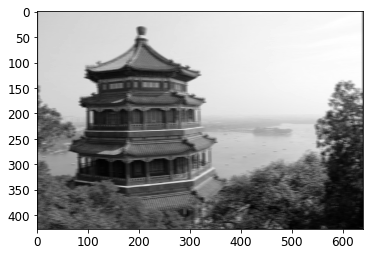

In [ ]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
plt.imshow(outputs[0, :, :, 1], cmap="gray")

Или можно создать сверточный слой, используя API keras. Значения фильтров при этом будут являеться tf.Variable и настраиваться в процессе обучения.

In [ ]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, 
                           padding="same", activation="relu")

#Pooling layers

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2)
avg_pool = keras.layers.AvgPool2D(pool_size=2)

**depthwise max pooling layer**

*strides=(1,1,1... ) - указывают на соответствующее смещение вдоль batch набора по высоте и ширине изображения*

*strides=(... 3) - указывает глубину (кол-во слоев CNN)*


In [ ]:
depth_pool = keras.layers.Lambda(
    lambda X: tf.nn.max_pool(X, ksize=(1, 1, 1, 3), 
                             strides=(1, 1, 1, 3),
                             padding="valid"))

**global average pooling layer**

In [ ]:
glob_avg_pool = keras.layers.GlobalAvgPool2D()

#CNN Architectures

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train.reshape(-1, 28, 28, 1)
X_valid = X_valid.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same",
                        input_shape=[28, 28, 1]),
  keras.layers.MaxPooling2D(2),
  keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
  keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
  keras.layers.MaxPooling2D(2),
  keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
  keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
  keras.layers.MaxPooling2D(2),
  keras.layers.Flatten(),
  keras.layers.Dense(256, activation="relu"),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(128, activation="relu"),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(64, activation="relu"),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='nadam',  metrics=["accuracy"])
model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 37s 22ms/step - loss: 0.8093 - accuracy: 0.7183 - val_loss: 0.4585 - val_accuracy: 0.8502
Epoch 2/5
1719/1719 [==============================] - 37s 21ms/step - loss: 0.4634 - accuracy: 0.8474 - val_loss: 0.3717 - val_accuracy: 0.8748
Epoch 3/5
1719/1719 [==============================] - 37s 21ms/step - loss: 0.4009 - accuracy: 0.8682 - val_loss: 0.3435 - val_accuracy: 0.8724
Epoch 4/5
1719/1719 [==============================] - 37s 21ms/step - loss: 0.3767 - accuracy: 0.8759 - val_loss: 0.3571 - val_accuracy: 0.8798
Epoch 5/5
1719/1719 [==============================] - 37s 21ms/step - loss: 0.3522 - accuracy: 0.8851 - val_loss: 0.3109 - val_accuracy: 0.8888


In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.3186 - accuracy: 0.8866


[0.31862568855285645, 0.8866000175476074]

#Implementing a ResNet-34 CNN Using Keras

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

Next, we can build the ResNet-34 using a Sequential model

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3], 
                              padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

#Using Pretrained Models from Keras

In [ ]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 3s 0us/step


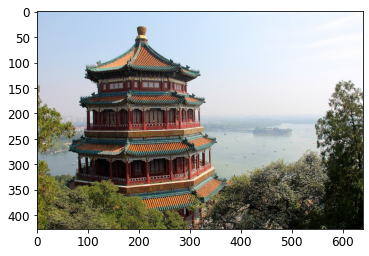

In [ ]:
china = load_sample_image("china.jpg")
plt.imshow(china)

china имеет разрешение (427, 640), а модель resnet ожидает изображение с рашрешением (224, 224), поэтому изображение придется обрезать и отмасштабировать

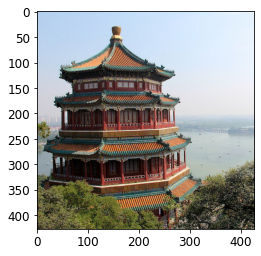

In [ ]:
china2 = tf.image.crop_to_bounding_box(china, 0, 50, 427, 427)
plt.imshow(china2)
china2 = tf.image.resize(china2, [224, 224])

теперь перед тем как вызывать фукнцию predict, необходимо обработать входные данные (обрезанное и масштабированное изображение)

In [ ]:
china3 = tf.reshape(china2, [1,224,224,3])
china3 = keras.applications.resnet50.preprocess_input(china3)

Предсказание возвращает результат в форме [images_size, 1000], где 1000 - вероятность принадлежности к одному из 1000 классов. сооветствие индекса классу определеяется функцией decode_predictions

In [ ]:
y_proba = model.predict(china3)
y_proba.shape

(1, 1000)

In [ ]:
for i, n in enumerate(y_proba.reshape(-1)):
  if n > 1e-2: print('class i{} = {:.2f}%'.format(i, n*100))

class i442 = 24.00%
class i663 = 36.65%
class i698 = 37.12%


In [ ]:
keras.applications.resnet50.decode_predictions(y_proba, top=3)

[[('n03877845', 'palace', 0.3711913),
  ('n03781244', 'monastery', 0.36653805),
  ('n02825657', 'bell_cote', 0.23999692)]]

#Pretrained Models for Transfer Learning

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples # 3670
class_names = info.features["label"].names # ["dandelion", "daisy", ...]
n_classes = info.features["label"].num_classes # 5
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.0,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

набор данных имеет только train, поэтому придется разделить этот набор данных

In [ ]:
test_set, valid_set, train_set = tfds.load("tf_flowers", 
  split=["train[:10%]", "train[10%:25%]", "train[25%:]"], as_supervised=True)

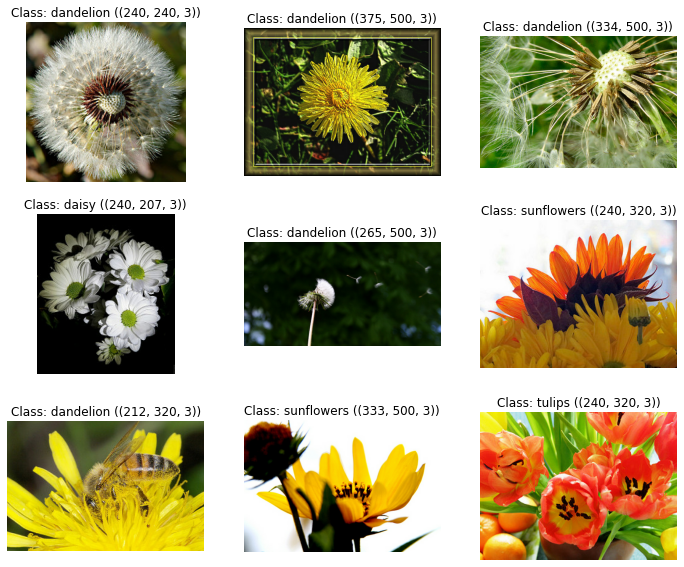

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {} ({})".format(class_names[label], image.shape))
    plt.axis("off")

plt.show()

In [ ]:
def preprocess(image, label):
  resized = tf.image.resize(image, [224,224])
  final = keras.applications.xception.preprocess_input(resized)
  return final, label

In [ ]:
batch_size = 32

train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set  = test_set.map(preprocess).batch(batch_size).prefetch(1)

In [ ]:
xception_model = keras.applications.xception.Xception(weights="imagenet")
xception_model.layers[-10:]

91889664/91884032 [==============================] - 1s 0us/step


In [ ]:
xception_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
xception_model.layers[-8:]

In [ ]:
pooling_layer = keras.layers.GlobalAveragePooling2D()(xception_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(pooling_layer)
model = keras.Model(inputs=xception_model.input, outputs=output)

In [ ]:
for layer in xception_model.layers:
  layer.trainable = False

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(train_set, epochs=5, validation_data=valid_set)
model.evaluate(test_set)

Epoch 1/5
86/86 [==============================] - 33s 388ms/step - loss: 1.0349 - accuracy: 0.8016 - val_loss: 0.9968 - val_accuracy: 0.8330
Epoch 2/5
86/86 [==============================] - 32s 374ms/step - loss: 0.3157 - accuracy: 0.9204 - val_loss: 0.6268 - val_accuracy: 0.8730
Epoch 3/5
86/86 [==============================] - 32s 374ms/step - loss: 0.1449 - accuracy: 0.9517 - val_loss: 0.6168 - val_accuracy: 0.8802
Epoch 4/5
86/86 [==============================] - 32s 372ms/step - loss: 0.0711 - accuracy: 0.9767 - val_loss: 0.6171 - val_accuracy: 0.8693
Epoch 5/5
12/12 [==============================] - 4s 337ms/step - loss: 0.5797 - accuracy: 0.8856


[0.579674482345581, 0.8855586051940918]

In [ ]:
for layer in xception_model.layers: layer.trainable = True
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(train_set, epochs=5, validation_data=valid_set)
model.evaluate(test_set)

Epoch 1/5
      2/Unknown - 1s 612ms/step - loss: 0.9039 - accuracy: 0.7344WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3293s vs `on_train_batch_end` time: 0.8943s). Check your callbacks.


86/86 [==============================] - 111s 1s/step - loss: 0.3390 - accuracy: 0.8823 - val_loss: 0.6615 - val_accuracy: 0.8566
Epoch 2/5
86/86 [==============================] - 111s 1s/step - loss: 0.0829 - accuracy: 0.9764 - val_loss: 0.4557 - val_accuracy: 0.8784
Epoch 3/5
86/86 [==============================] - 111s 1s/step - loss: 0.0272 - accuracy: 0.9920 - val_loss: 0.2718 - val_accuracy: 0.9093
Epoch 4/5
86/86 [==============================] - 111s 1s/step - loss: 0.0104 - accuracy: 0.9967 - val_loss: 0.2836 - val_accuracy: 0.9147
Epoch 5/5
12/12 [==============================] - 3s 276ms/step - loss: 0.2890 - accuracy: 0.9428


[0.2890469431877136, 0.9427793025970459]

#Classification and Localization

In [ ]:
def add_random_bounding_boxes(images, labels):
    size = tf.shape(images)[0]
    fake_bboxes = tf.random.uniform([size, 4])
    return images, (labels, fake_bboxes)

In [ ]:
fake_train_set = train_set.take(10).map(add_random_bounding_boxes)

In [ ]:
reg_output = keras.layers.Dense(4)(pooling_layer)
model = keras.models.Model(inputs=xception_model.input, outputs=[output, reg_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

In [ ]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
2/5 [===========>..................] - ETA: 3s - loss: 0.0649 - dense_1_loss: 0.0041 - dense_3_loss: 0.3083 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.3281WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3597s vs `on_train_batch_end` time: 0.9311s). Check your callbacks.


5/5 [==============================] - 6s 1s/step - loss: 0.0906 - dense_1_loss: 0.0396 - dense_3_loss: 0.2946 - dense_1_accuracy: 0.9937 - dense_3_accuracy: 0.2688
Epoch 2/2
5/5 [==============================] - 6s 1s/step - loss: 0.0535 - dense_1_loss: 0.0087 - dense_3_loss: 0.2324 - dense_1_accuracy: 0.9937 - dense_3_accuracy: 0.2625


#Tasks

###task1

*What are the advantages of a CNN over a fully connected DNN for image classification?*

- существенно меньшее кол-во весовых коэф-в (последовательные слои только частично соеденены) и соответственно необходимой памяти и вычислительной нагрузки при схожих размерностях. Кроме того, это делает CNN модель менее склоннной к переобучению.

- сверточные сети могут определять патерны вдоль размерности, так и вдоль каналов входящего изображения. Обнаруженные паттерны храняться в фильтрах, которые применяются ко всем частям изображения с заданным шагам, в отличае от DNN, где паттерн находится в четко определенном месте

- Finally, a DNN has no prior knowledge of how pixels are organized; it does not know that nearby pixels are close. A CNN’s architecture embeds this prior knowledge. Lower layers typically identify features in small areas of the images, while higher layers combine the lower-level features into larger features. This works well with most natural images, giving CNNs a decisive head start compared to DNNs.

###task2

*Consider a CNN composed of three convolutional layers, each with 3 × 3 kernels, a stride of 2, and "same" padding. The lowest layer outputs 100 feature maps, the middle one outputs 200, and the top one outputs 400. The input images are RGB images of 200 × 300 pixels.*

*What is the total number of parameters in the CNN? If we are using 32-bit floats, at least how much RAM will this network require when making a prediction for a single instance? What about when training on a mini-batch of 50 images?*

l1: 3x3x3(RGB)x100(filters)+100(bias)=2'800 весов,
размерность feature maps ~100x150, RAM 100x150x100(feature maps)=6MB

l2: 3x3x100(l1 feature maps)x200+200(bias)=180'200 весов,
размерность feature maps ~50x75, RAM 50x75x200(feature maps)=3MB

l3: 3x3x200(l2 feature maps)x400+400(bias)=720'400 весов,
размерность feature maps ~25x37, RAM 25x37x400(feature maps)=1.5MB

Итого: 903'400 весовых коэ-в и 3.6MB . Как только вывод слоя бдует расчетан, вывод предыдущего может освободить память, поэтому max нужно 6+3=9MB. Т.о. 3,6+9=12,6Mb на предсказание.

Вычислим сколько нужно памяти на обучение при batch_size=50. 50 изображений RGB - 36MB, т.к. вывод каждого слоя выгружать нельзя из-за autodiff (6+3+1.5)*50=525Mb и веса 3.6MB => 36+525+3.6=564.6Mb

###task3

*If your GPU runs out of memory while training a CNN, what are five things you could try to solve the problem?*

- уменьшить размер batch_size;
- уменьшить кол-во слоев и/или фильров;
- уменьшить разрешение изображений обучающего набора;
- использовать float16;
- Reduce dimensionality using a larger stride in one or more layers;
- Distribute the CNN across multiple devices.

###task4

*Why would you want to add a max pooling layer rather than a convolutional layer with the same stride?*

pooling не имеет весовых коэф-в и не обучается.

###task5

*When would you want to add a local response normalization layer?*

Подобным образом работают биологические нейроны и использование этой технологии дало преимущество AlexNet. Как я понял эта технология позволяет более четко и быстро выделять паттерны, когда нейрон с сильной активацией подавлят нейроны в той же позиции в других feature maps по сути уменьшая их влияние на нахождение возможных других незначительных паттернов или просто шума.

A local response normalization layer makes the neurons that most strongly activate inhibit neurons at the same location but in neighboring feature maps, which encourages different feature maps to specialize and pushes them apart, forcing them to explore a wider range of features. It is typically used in the lower layers to have a larger pool of low-level features that the upper layers can build upon

###task6

*Can you name the main innovations in AlexNet, compared to LeNet-5? What about the main innovations in GoogLeNet, ResNet, SENet, and Xception?*

1) LeNet достаточно простая сеть с слоями CNN, pooling и dense слоями на верху стека. 

2) AlexNet начал использовать слои dropout, складывать CNN слои друг на друга и использовать data augmentaion а так же технологию local response normaliztion

3) GoogleLeNet внедрила понятие "модуля начала", который представляет собой разделение ввода на несколко слоев CNN параллельно с 1x1 kernel size и над которыми находятся другие слои CNN c большими kernel_size, что позволяет эффективно использовать парметры (в 10 раз меньше весов чем алекснет) и определять паттерны в различных машстабах, включая определение паттернов вглубь. В итоге сеть получилась более глубокой.

3) Xception пытается отдельны выявлять пространственные паттерны и межканальные.

4) SeNET описывате блок dense, который обучается на том, какие слои обычно активируются вместе и при необходимости усиливает их сигнал

###task7

*What is a fully convolutional network? How can you convert a dense layer into a convolutional layer?*

FCN сеть - сеть, где выходной слой вместо dense заменяется на CNN. Т.к. кол-во весов по сути тоже, то можно использовать те же веса. Преимущество - обработка изображений почти любого размера. В случае на входе изображения большего размера, CNN выходной слой будет давать предсказание для каждой ячейки изображения.

Конвертируется путем переноса весов, приэтом CNN будет содержать фильтры 1x1 в кол-ве равном кол-ву нейронов dense.

###task8

*What is the main technical difficulty of semantic segmentation?*

The main technical difficulty of semantic segmentation is the fact that a lot of the spatial information gets lost in a CNN as the signal flows through each layer, especially in pooling layers and layers with a stride greater than 1. This spatial information needs to be restored somehow to accurately predict the class of each
pixel.

###task9

*Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST.*

In [ ]:
(x_full, y_full), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
x_full = x_full.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

x_full = x_full.reshape(-1, 28,28,1)
x_test = x_test.reshape(-1, 28,28,1)

In [ ]:
idxs = np.arange(len(x_full))
np.random.shuffle(idxs)

x_full = x_full[idxs]
y_full = y_full[idxs]

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  keras.layers.Conv2D(filters=32, kernel_size=14, strides=1, activation='relu',
                      input_shape=[28,28,1], padding='same'),
  keras.layers.MaxPool2D(2),
  keras.layers.Conv2D(filters=64, kernel_size=7, strides=1, activation='relu',  padding='same'),
  keras.layers.MaxPool2D(2),
  keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, activation='relu',  padding='same'),
  keras.layers.MaxPool2D(2),
  keras.layers.Conv2D(filters=264, kernel_size=1, strides=1, activation='relu',  padding='same'),
  keras.layers.MaxPool2D(2),
  keras.layers.Flatten(), 
  keras.layers.Dropout(0.4),
  keras.layers.Dense(200, activation='relu'),
  keras.layers.Dense(10, activation='softmax')
])

In [ ]:
earlyStopping_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
save_cb = ModelCheckpoint('task10_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(x_full, y_full, epochs=40, callbacks=[earlyStopping_cb, save_cb], validation_split=0.25)

Epoch 1/40
1407/1407 [==============================] - 15s 11ms/step - loss: 0.2154 - accuracy: 0.9336 - val_loss: 0.0897 - val_accuracy: 0.9734
Epoch 2/40
1407/1407 [==============================] - 15s 11ms/step - loss: 0.0628 - accuracy: 0.9825 - val_loss: 0.0479 - val_accuracy: 0.9858
Epoch 3/40
1407/1407 [==============================] - 15s 10ms/step - loss: 0.0491 - accuracy: 0.9853 - val_loss: 0.0507 - val_accuracy: 0.9843
Epoch 4/40
1407/1407 [==============================] - 15s 10ms/step - loss: 0.0384 - accuracy: 0.9890 - val_loss: 0.0571 - val_accuracy: 0.9869
Epoch 5/40
1407/1407 [==============================] - 15s 10ms/step - loss: 0.0323 - accuracy: 0.9904 - val_loss: 0.0365 - val_accuracy: 0.9905
Epoch 6/40
1407/1407 [==============================] - 15s 10ms/step - loss: 0.0305 - accuracy: 0.9917 - val_loss: 0.0590 - val_accuracy: 0.9878
Epoch 7/40
1407/1407 [==============================] - 15s 10ms/step - loss: 0.0259 - accuracy: 0.9928 - val_loss: 0.0451 -

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0503 - accuracy: 0.9910


[0.05033260956406593, 0.9909999966621399]

###taks11

https://www.tensorflow.org/tutorials/generative/style_transfer